<a href="https://colab.research.google.com/github/Aadithyan2003/Sales-Forecast/blob/main/Sales_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [75]:
import os

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Dense,LSTM
#from tensorflow.keras.callbacks import EarlyStopping,ModelCheckpoint

In [77]:
dataset=pd.read_csv('/content/sales forecast dataset.csv')
dataset.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


Checking null values in dataset

In [78]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


Dropping store and item columns because we are doing sales analysis

In [79]:
dataset=dataset.drop(['store','item'],axis=1)

In [80]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


As we see date column in in object datatype,we need to convert to Date time datatype

In [81]:
dataset['date'] = pd.to_datetime(dataset['date'], format='%Y-%m-%d', errors='coerce')

# Check for any invalid dates (NaT) after conversion
invalid_dates = dataset[dataset['date'].isnull()]
print(invalid_dates)

Empty DataFrame
Columns: [date, sales]
Index: []


In [82]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 13.9 MB


In [83]:
dataset.head()

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10


Converting date to month period and sum the number of items in each month

In [84]:
# Check the data type of the 'date' column
print(dataset['date'].dtype)

# If the 'date' column is already a Period object, you don't need to convert it again.
# If it's not, you can proceed with the conversion:
if dataset['date'].dtype != 'period[M]':
    dataset['date'] = dataset['date'].dt.to_period("M")

monthly_sales = dataset.groupby('date').sum().reset_index()

datetime64[ns]


In [85]:
monthly_sales['date']=monthly_sales['date'].dt.to_timestamp()

In [86]:
#monthly_sales=monthly_sales.drop(['date]'],axis=1)
monthly_sales.head()
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    60 non-null     datetime64[ns]
 1   sales   60 non-null     int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 1.1 KB


Visualization of monthly sales

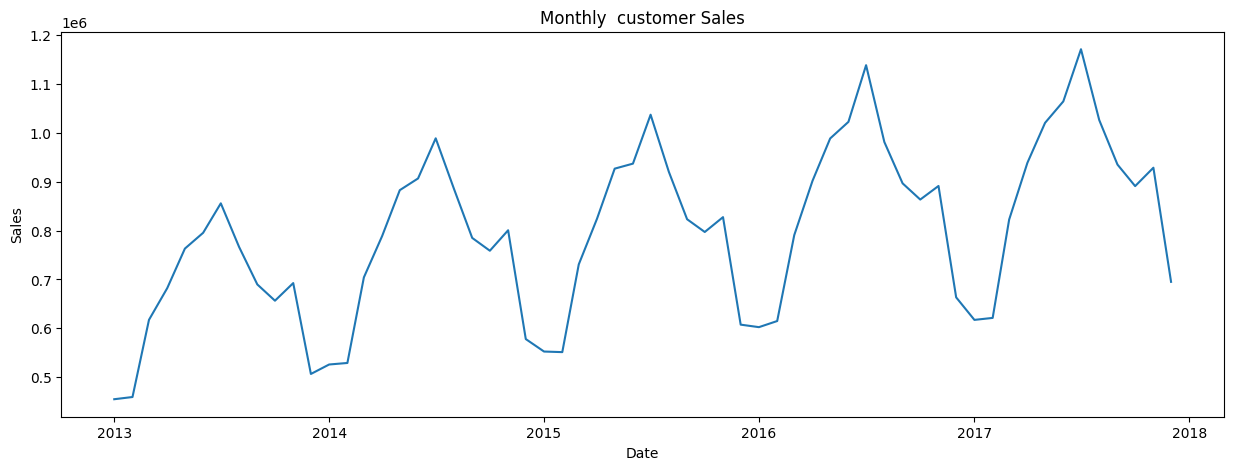

In [87]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly  customer Sales")
plt.show()

Call the difference on the sales column to make the sales data stationery

In [88]:
monthly_sales['sales_diff']=monthly_sales['sales'].diff()
monthly_sales=monthly_sales.dropna()
monthly_sales.head(10)

,date,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


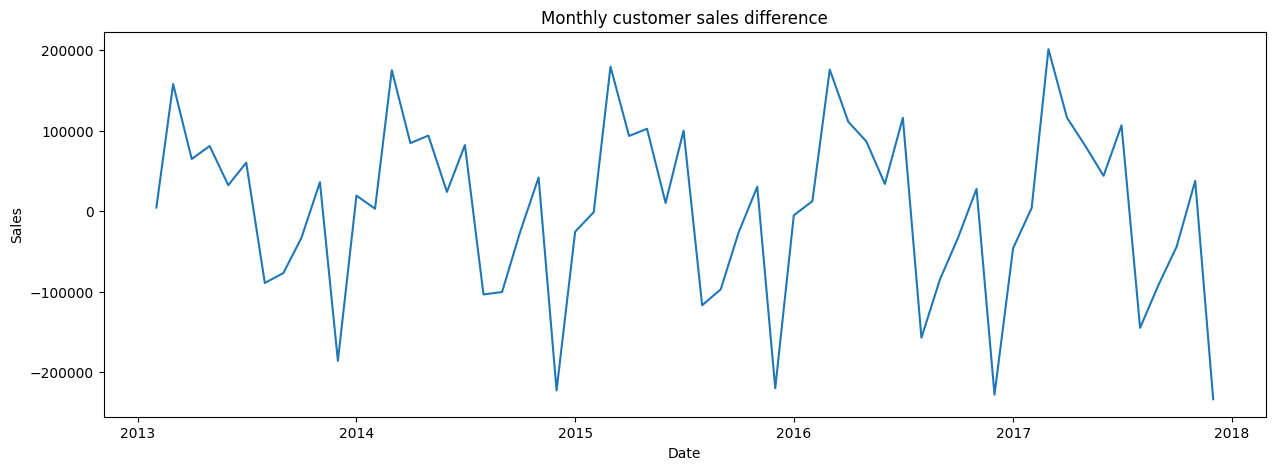

In [89]:
plt.figure(figsize=(15,5))
plt.plot(monthly_sales['date'],monthly_sales['sales_diff'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Monthly customer sales difference")
plt.show()

Dropping the sales and date in order to train the model

In [90]:
supervised_data=monthly_sales.drop(['date','sales'],axis=1)

preparing the superised data for ml algo


In [91]:
for i in range(1,13):    #creates 1-12 month
    col_name='month_'+str(i)    #create columns month_1.....month_12
    supervised_data[col_name]=supervised_data['sales_diff'].shift(i)    #feed values in the columns .shift help to shift column to column to feed data
supervised_data=supervised_data.dropna().reset_index(drop=True)
supervised_data.head(10)


,sales_diff,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0,4513.0
1,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0,157965.0
2,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0,64892.0
3,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0,80968.0
4,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0,32355.0
5,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0,60325.0
6,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0,-89161.0
7,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0,-76854.0
8,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0,-33320.0
9,41900.0,-26241.0,-100472.0,-103414.0,82168.0,23965.0,93963.0,84613.0,175184.0,3130.0,19380.0,-186036.0,36056.0


SPLITTING THE DATA TO TRAIN AND TEST

In [92]:
train_data=supervised_data[:-12]  #for previous 12 months
test_data=supervised_data[-12:]   #for upcoming 12 months
print('train data shape: ',train_data.shape)
print('test data shape: ',test_data.shape)

train data shape:  (35, 13)
test data shape:  (12, 13)


In [93]:
scaler=MinMaxScaler(feature_range=(-1,1)) #this makes feature values range from -1 to +1
scaler.fit(train_data)
train_data=scaler.transform(train_data)
test_data=scaler.transform(test_data)

In [94]:
x_train,y_train=train_data[:,1:],train_data[:,0:1] #selects all rows and columns from the second to the last column. This is typically used to extract feature columns
x_test,y_test=test_data[:,1:],test_data[:,0:1]
y_train=y_train.ravel() #ravel flats the data means putting matrix in a single line
y_test=y_test.ravel()
print("X_train shape",x_train.shape)
print("Y_train shape",y_train.shape)
print("X_test shape",x_test.shape)
print("Y_test shape",y_test.shape)

X_train shape (35, 12)
Y_train shape (35,)
X_test shape (12, 12)
Y_test shape (12,)


Make prediction data frame to merge the predicted sales prices of all the trained algos

In [95]:
#extracting last 12 dates and reset index ensures that old index is not added
sales_dates=monthly_sales['date'][-12:].reset_index(drop=True)
predict_df=pd.DataFrame(sales_dates)

In [96]:
act_sales=monthly_sales['sales'][-13:].to_list()
print(act_sales)
#access the last 13 months sales and convert into a list and print them

[663411, 617306, 621369, 822667, 938862, 1020686, 1064624, 1171393, 1026403, 935263, 891160, 928837, 695170]


To create the linear regression model and predicted outputs

In [97]:
lr_model=LinearRegression()
lr_model.fit(x_train,y_train)
lr_pre=lr_model.predict(x_test)


In [98]:
lr_pre=lr_pre.reshape(-1,1)  #This reshapes lr_pre into a 2D array (which was 1D array previously) with one column

#lr_pre_test_set is a set matrix- it contains the predicted output and input features of the test data

lr_pre_test_set=np.concatenate([lr_pre,x_test],axis=1)
lr_pre_test_set=scaler.inverse_transform(lr_pre_test_set)
# the last line help to inverse the transform which we did in minmaxscaler.The inverse transformation converts the scaled values back to their original scale.


In [99]:
result_list=[]

#Iterate over the indices of lr_pre_test_set
for index in range(0,len(lr_pre_test_set)):
  result_list.append(lr_pre_test_set[index][0]+act_sales[index]) #Append the sum of the prediction and actual sales to result_list
lr_pre_series=pd.Series(result_list,name='Linear Prediction')
predict_df=predict_df.merge(lr_pre_series,left_index=True,right_index=True) #Merge lr_pre_series with predict_df on their indices:

In [100]:
print(predict_df)

         date  Linear Prediction
0  2017-01-01       6.479148e+05
1  2017-02-01       6.283374e+05
2  2017-03-01       8.195190e+05
3  2017-04-01       9.436391e+05
4  2017-05-01       1.033653e+06
5  2017-06-01       1.065286e+06
6  2017-07-01       1.201561e+06
7  2017-08-01       1.002123e+06
8  2017-09-01       9.415142e+05
9  2017-10-01       9.080646e+05
10 2017-11-01       9.167461e+05
11 2017-12-01       6.947978e+05


Using our evaluation metrices

1) Mean Squared Error(MSE)

2) Mean Absolute Error(MAE)

3)R2_SCORE

In [101]:
#use the name which used while creating pd.series ("Linear Prediction")
lr_rmse=np.sqrt(mean_squared_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:]))
lr_mse=mean_squared_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
lr_mae=mean_absolute_error(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
lr_r2 = r2_score(predict_df['Linear Prediction'],monthly_sales['sales'][-12:])
print("Linear Regression ROOT MSE: ",lr_rmse,"\n")
print("Linear Regression MSE: ",lr_mse,"\n")
print("Linear Regression MAE: ",lr_mae,"\n")
print("Linear Regression R2: ",lr_r2,"\n")

Linear Regression ROOT MSE:  16221.272385416869 

Linear Regression MSE:  263129677.80188787 

Linear Regression MAE:  12433.184266490736 

Linear Regression R2:  0.9906152516380969 



Visualization of the prediction against the actual sales

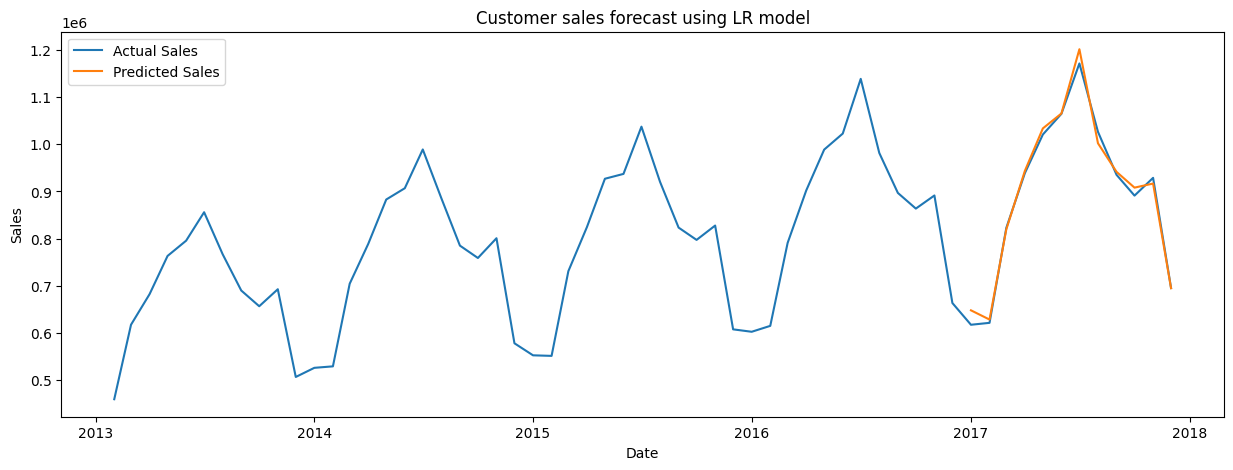

In [102]:
plt.figure(figsize=(15,5))
#For actual sales
plt.plot(monthly_sales['date'],monthly_sales['sales'])
#for predicted sales
plt.plot(predict_df['date'],predict_df['Linear Prediction'])
plt.xlabel("Date")
plt.ylabel("Sales")
plt.title("Customer sales forecast using LR model")
plt.legend(['Actual Sales','Predicted Sales'])
plt.show()

Result:- As we predicted last 12 months sales (i.e from 2017-2018), we can see that the actual and predicted are almost close , however we can see some steepness or light difference in the month around july-sept but we are close and almost equal in first 4-5 months and last 2-3 months